<a href="https://colab.research.google.com/github/dsadasafd/GAN/blob/main/%E2%80%9Cmnist_first_attempt_improved_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [84]:
import torch
import torch.nn as nn
import numpy, pandas, random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset


In [85]:
class MnistDataset(Dataset):
  
  
  # 超调用继承
  def __init__(self, csv_file):
   
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  
  
  def __len__(self):
    return len(self.data_df)

  
  
  def __getitem__(self, index):
    
    # dataset body content
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_data = torch.FloatTensor(self.data_df.iloc[index, 1:].values)/255.0

    return label, image_data, target

  
  
  def plot_image(self, index):
    
    image_arr = self.data_df.iloc[index, 1:].values.reshape(28,28)
    plt.imshow(image_arr, interpolation='none', cmap='Blues')
    plt.title('label = ' + str(self.data_df.iloc[index, 0]))

    pass


In [86]:
## load data

mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/mnist_data/mnist_train.csv')

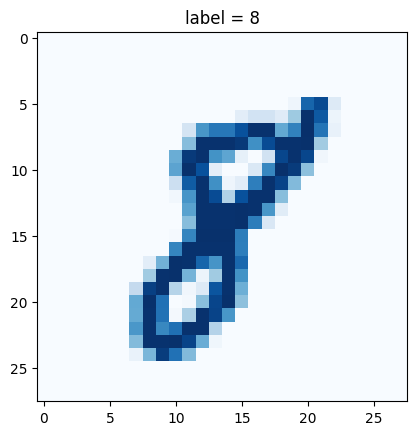

In [87]:
## check the data

mnist_dataset.plot_image(17)

In [88]:
# 创建一个判别器

class Discriminator(nn.Module):

  def __init__(self):
    
    # 初始化继承父类 
    super().__init__()
    
    # 构建网络body
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 损失函数使用MSELoss
    self.loss_function = nn.BCELoss()

    # 优化器使用
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 计数器和loss记录
    self.counter = 0
    self.progress = []

    pass



  def forward(self, inputs):
    return self.model(inputs)



  def train(self, inputs, targets):

    outputs = self.forward(inputs)
    loss = self.loss_function(outputs, targets)

    # 记录训练过程
    self.counter += 1
    
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    if (self.counter % 10000 == 0):
      print('counter = ', self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):

    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 0.25, 0.5, 1.0, 5.0))
    pass


In [89]:
def generate_random(size):

  random_data = torch.rand(size)

  return random_data


def generate_random_seed(size):
  
  random_data = torch.randn(size)

  return random_data

In [90]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:

  # 训练真实数据
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # 训练生成数据
  D.train(generate_random(784), torch.FloatTensor([0.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 34s, sys: 580 ms, total: 4min 34s
Wall time: 4min 38s


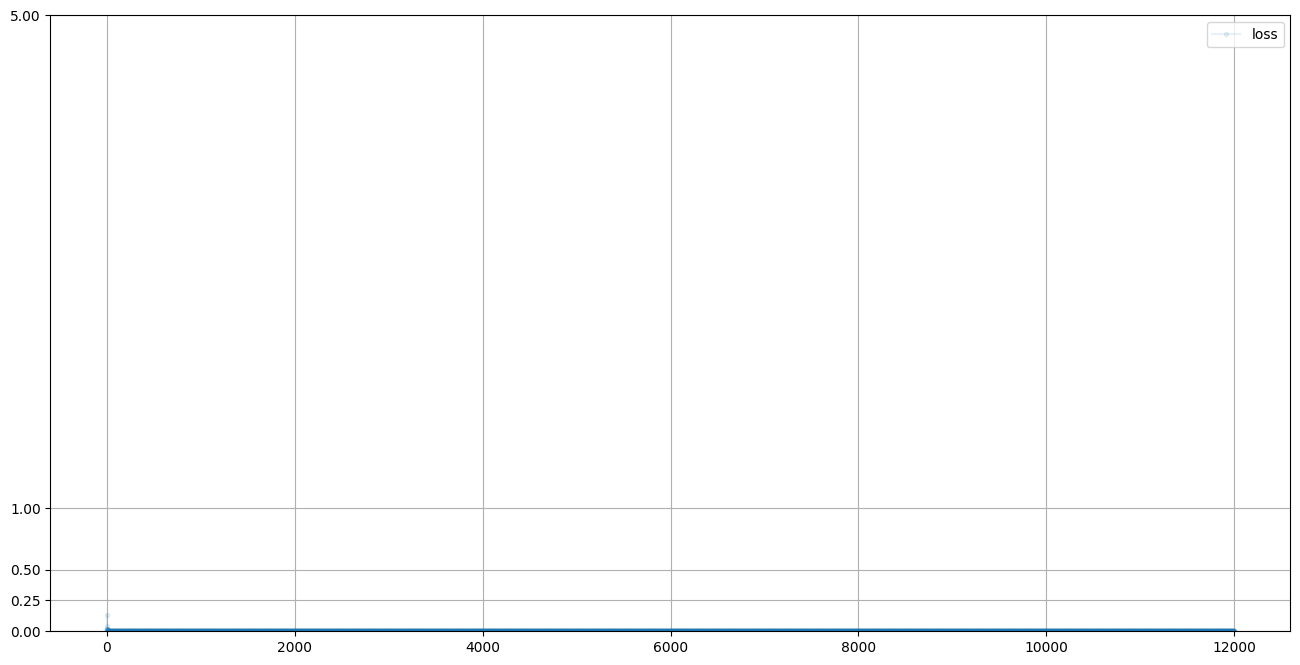

In [91]:
D.plot_progress()

In [92]:
# 测试一下鉴别器
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor))

for i in range(4):
  print(D.forward(generate_random(784)))

tensor([1.], grad_fn=<SigmoidBackward0>)
tensor([1.], grad_fn=<SigmoidBackward0>)
tensor([1.], grad_fn=<SigmoidBackward0>)
tensor([1.], grad_fn=<SigmoidBackward0>)
tensor([1.0307e-11], grad_fn=<SigmoidBackward0>)
tensor([9.0672e-12], grad_fn=<SigmoidBackward0>)
tensor([9.9078e-12], grad_fn=<SigmoidBackward0>)
tensor([9.7595e-12], grad_fn=<SigmoidBackward0>)


In [93]:
# 创建生成器

class Generator(nn.Module):


  def __init__(self):
    super().__init__()
    pass

    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200,784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.progress = []

    pass


  def forward(self, inputs):
    return self.model(inputs)


  def train(self, D, inputs, targets):
    # 计算生成器和判别器的输出值
    g_outputs = self.forward(inputs)
    d_outputs = D.forward(g_outputs)

    loss = D.loss_function(d_outputs, targets)

    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 反向传播梯度优化权重
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass


  def plot_progress(self):

    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 0.25, 0.5, 1.0, 5.0))
    pass


pass




  


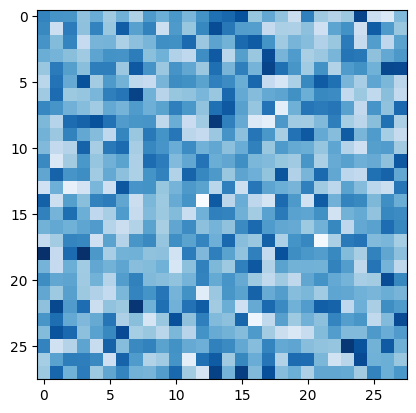

In [94]:
G = Generator()

G_output = G.forward(generate_random_seed(100))

image_data = G_output.detach().numpy().reshape(28, 28)

plt.imshow(image_data, interpolation='none', cmap='Blues')



In [95]:
## train the Gan 

%%time

D = Discriminator()
G = Generator()
epochs = 4

for i in range(epochs):

  print('epoch = ', i+1)
  for label, image_data_tensor, target_tensor in mnist_dataset:

    # 真实数据训练
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # 生成器数据的训练()
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
  

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 35min 3s, sys: 4.59 s, total: 35min 8s
Wall time: 35min 30s


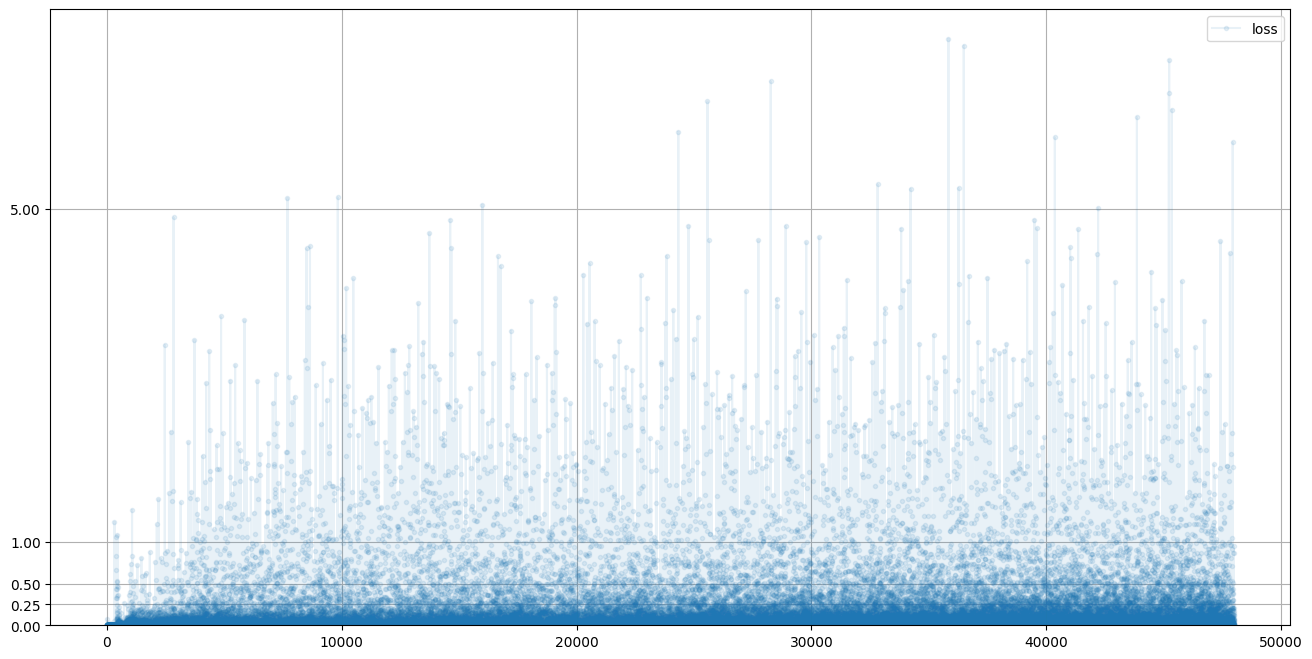

In [96]:
D.plot_progress()

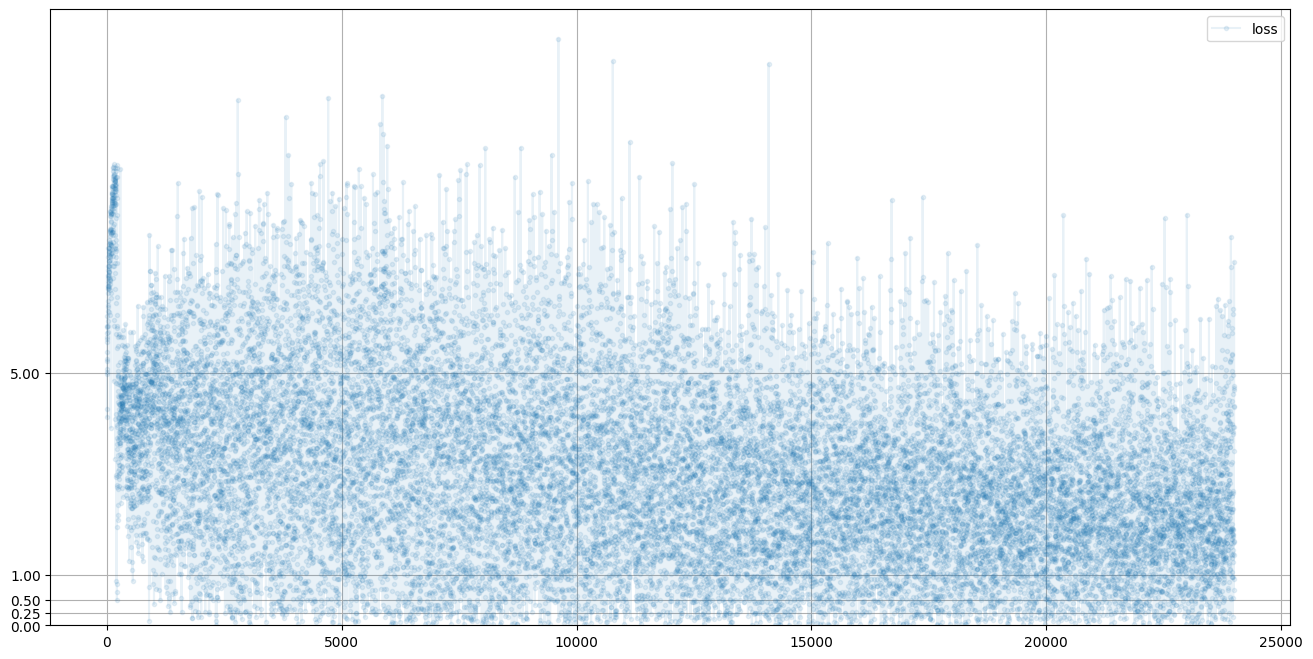

In [97]:
#G.progress
G.plot_progress()

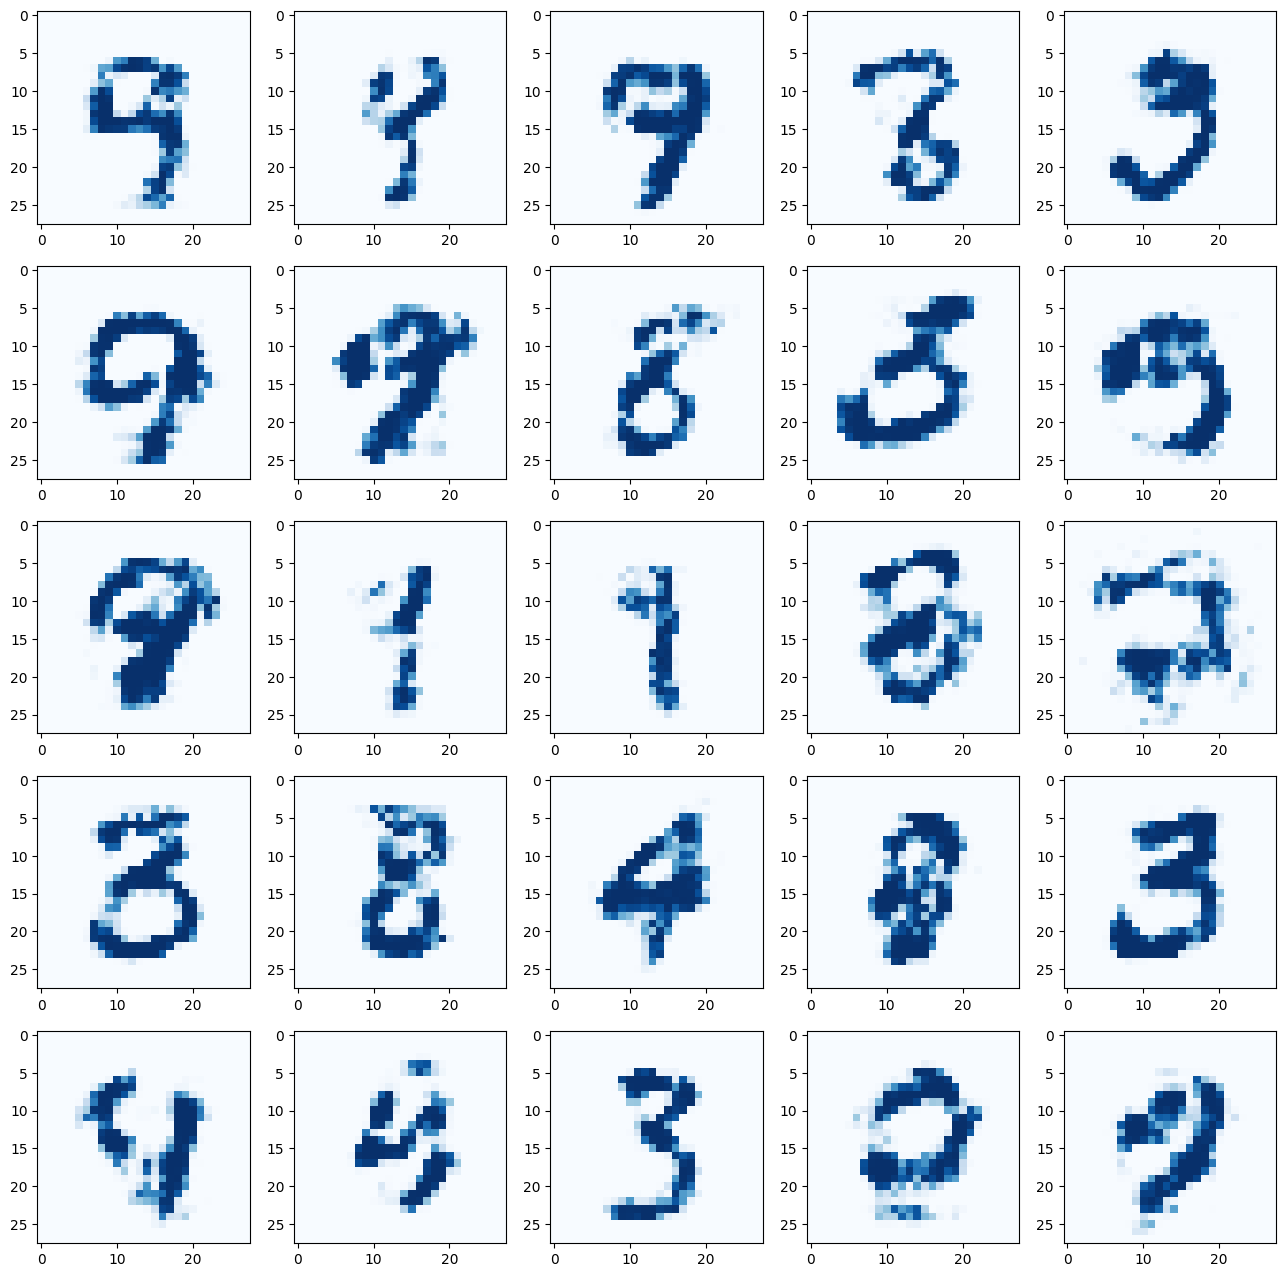

In [119]:
f, axarr = plt.subplots(5,5, figsize=(16,16))

for i in range(5):
  for j in range(5):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass

  pass



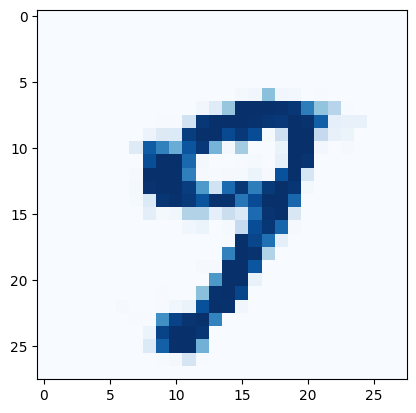

In [184]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')



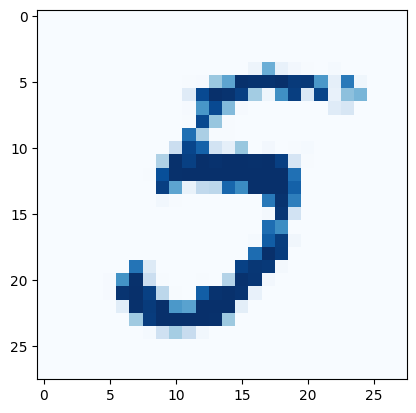

In [159]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

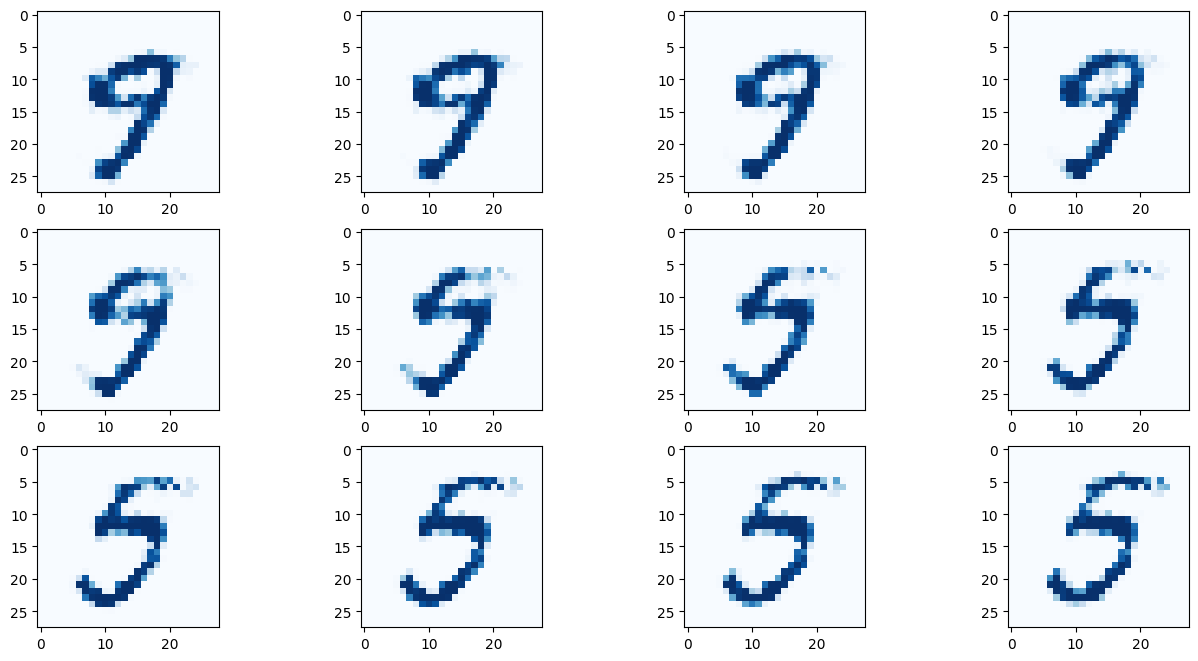

In [185]:
count = 0

f,axarr = plt.subplots(3,4, figsize=(16,8))

for i in range(3):
  for j in range(4):
    seed = seed1 +(seed2 - seed1)/11 * count
    output = G.forward(seed)
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    count += 1
    pass

  pass

  


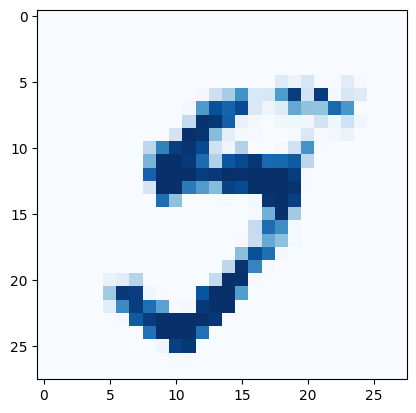

In [187]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

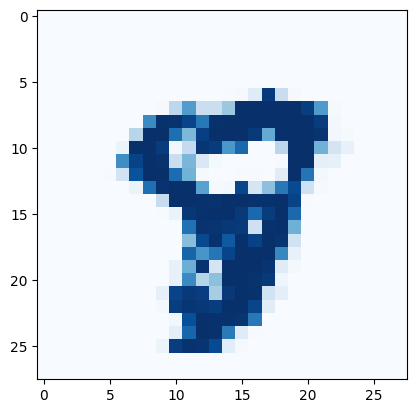

In [188]:
seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')